## 5.2 MLP分类模型

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler # 数据标准化预处理
from sklearn.model_selection import train_test_split # 数据集切分
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # 评价模型效果
from sklearn.manifold import TSNE # 数据降维及可视化
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
import torch.utils.data as Data
import matplotlib.pyplot as plt
import seaborn as sns # 可视化
import hiddenlayer as hl # 网络可视化
from torchviz import make_dot # 网络可视化

### 5.2.1 数据准备和探索

In [7]:
# 读取数据并显示数据的前几行
spam = pd.read_csv("spambase.csv")
spam.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [8]:
# 计算垃圾邮件和非垃圾邮件的数量
print(pd.value_counts(spam.label))
print(spam.shape)

0    2788
1    1813
Name: label, dtype: int64
(4601, 58)


> 前57列是邮件统计特征，第58列是邮件标签（0表示非垃圾邮件，1表示垃圾邮件）；共4601个样本，垃圾邮件1813个，非垃圾邮件有2788个

In [9]:
# 标准化数据
X = spam.iloc[:, 0:57].values
y = spam.label.values
scales = MinMaxScaler(feature_range=(0, 1))
X = scales.fit_transform(X)
# 划分训练集与测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123) # 25%作为测试集

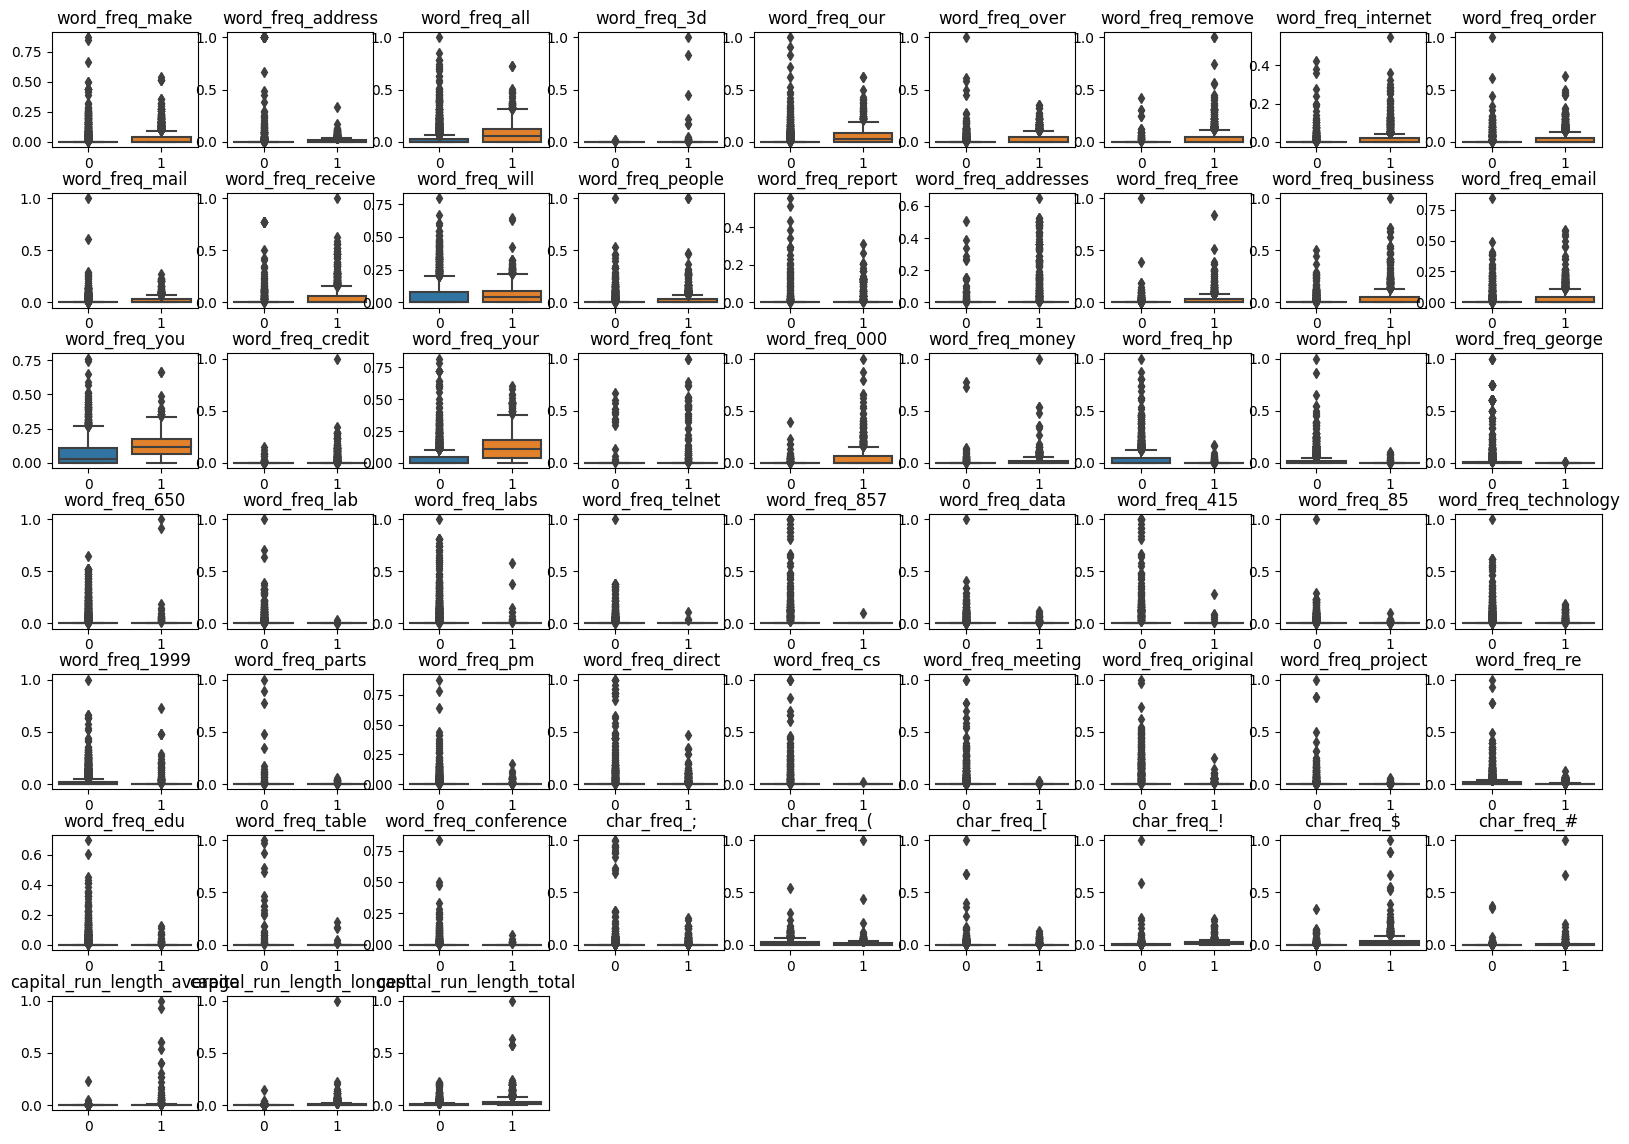

In [10]:
# 探索性数据分析
colname = spam.columns.values[:-1]
plt.figure(figsize=(20, 14))
for ii in range(len(colname)):
    plt.subplot(7, 9, ii+1)
    sns.boxplot(x = y_train, y = X_train[:, ii])
    plt.title(colname[ii])
plt.subplots_adjust(hspace=0.4)
plt.show()

### 5.2.2 搭建网络并可视化

In [11]:
# 全连接网络
class MLPclassifica(nn.Module):
    def __init__(self):
        super(MLPclassifica, self).__init__()
        #定义第一个隐藏层
        self.hidden1 = nn.Sequential(
            nn.Linear(
                in_features = 57, # 第一个隐藏层的输入，数据的特征数
                out_features = 30, # 第一个隐藏层的输出，神经元的数量
                bias = True # 默认会有偏置
            ),
            nn.ReLU()
        )
        # 定义第二个隐藏层
        self.hidden2 = nn.Sequential(
            nn.Linear(30, 10),
            nn.ReLU()
        )
        # 分类层
        self.classifica = nn.Sequential(
            nn.Linear(10, 2),
            nn.Sigmoid()
        )
    # 定义网络的前向传播路径
    def forward(self, x):
        fc1 = self.hidden1(x)
        fc2 = self.hidden2(fc1)
        output = self.classifica(fc2)
        # 输出为两个隐藏层和输出层
        return fc1, fc2, output
# 输出网络结构
mlpc = MLPclassifica()

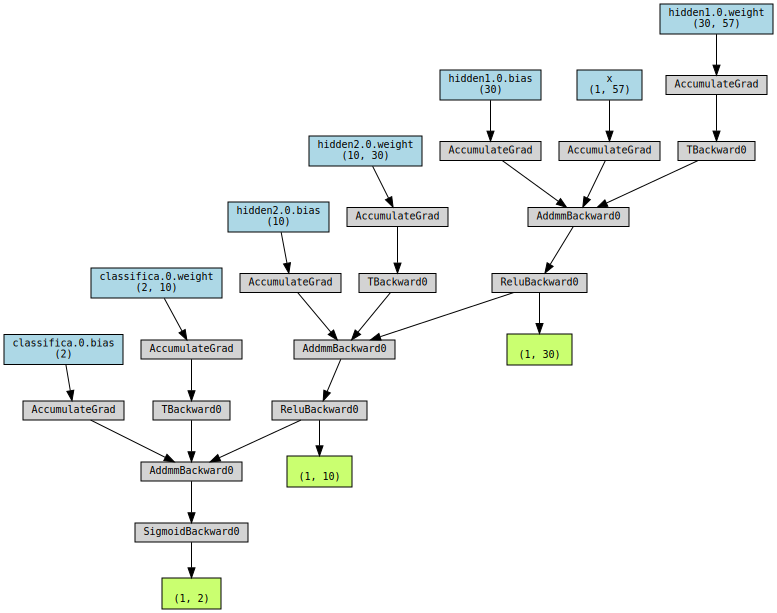

In [12]:
# 使用make_dot可视化网络
x = torch.randn(1, 57).requires_grad_(True)
y = mlpc(x)
Mymlpcvis = make_dot(y, params=dict(list(mlpc.named_parameters()) + [('x', x)]))
Mymlpcvis

### 5.2.4 使用预处理后的数据训练模型

In [15]:
# 将数据转化为张量
X_train_t = torch.from_numpy(X_train.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.int64))
X_test_t = torch.from_numpy(X_test.astype(np.float32))
y_test_t = torch.from_numpy(y_test.astype(np.int64))
# 将训练集转化为张良后，使用TensorDataset将X和y整理到一起
train_data = Data.TensorDataset(X_train_t, y_train_t)
# 定义一个数据加载器，将训练数据集进行批量处理
train_loader = Data.DataLoader(
    dataset = train_data, # 使用的数据集
    batch_size= 64, # 批处理样本大小
    shuffle = True, # 每次迭代前打乱数据
    num_workers = 1
)

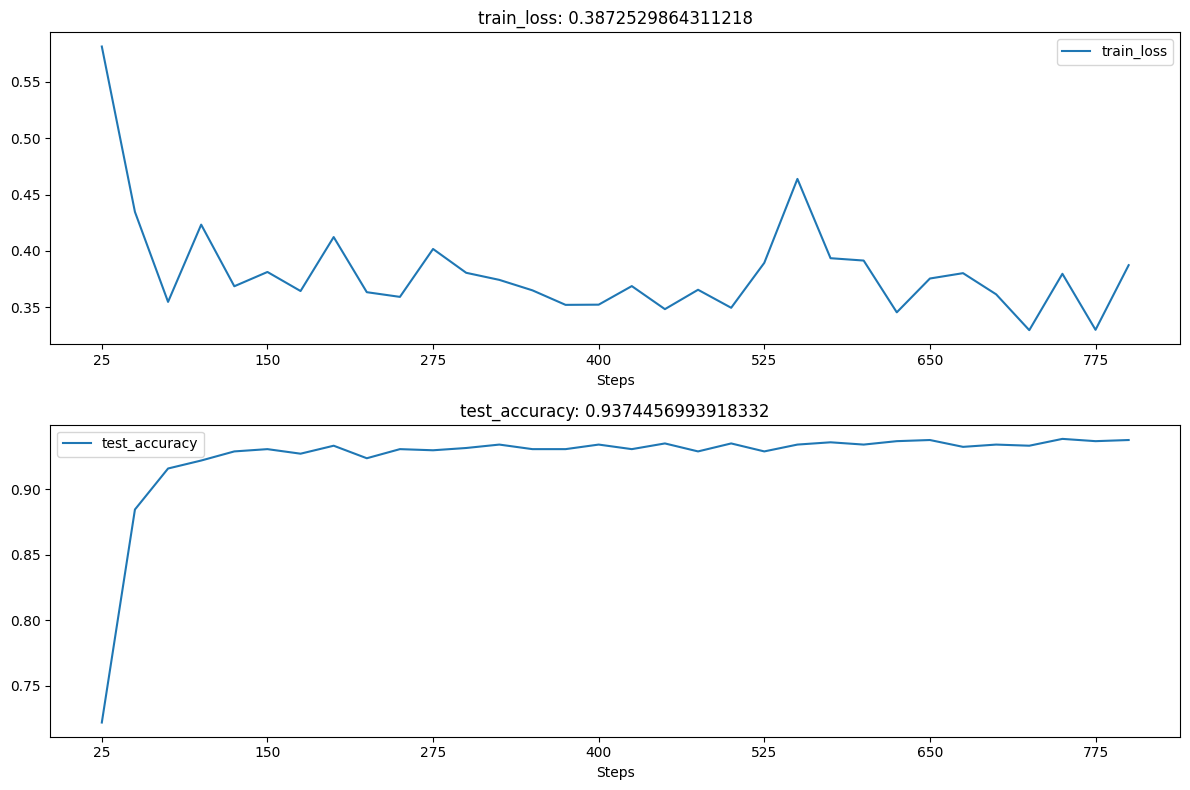

In [16]:
# 定义优化器
optimizer = torch.optim.Adam(mlpc.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss() # 二分类损失函数
# 记录训练过程的指标
history1 = hl.History()
# 使用Canvas进行可视化
canvas1 = hl.Canvas()
print_step = 25
# 对模型进行迭代训练，对所有的数据训练epoch轮
for epoch in range(15):
    # 对训练数据的加载器进行迭代计算
    for step, (b_x, b_y) in enumerate(train_loader):
        # 计算每个batch的损失
        _, _, output = mlpc(b_x) # MLP在训练batch上的输出
        train_loss = loss_func(output, b_y) # 二分类交叉熵损失函数
        optimizer.zero_grad() # 每个迭代步的梯度初始化为0
        train_loss.backward() # 损失的后向传播，计算梯度
        optimizer.step() # 使用梯度进行优化
        niter = epoch*len(train_loader)+step+1
        # 计算每经过print_step次迭代后的输出
        if niter % print_step == 0:
            _, _, output = mlpc(X_test_t)
            _, pre_lab = torch.max(output, 1)
            test_accuracy = accuracy_score(y_test, pre_lab)
            # 为history添加epoch，损失和精盾
            history1.log(niter, train_loss = train_loss, test_accuracy = test_accuracy)
            # 使用两个图像可视化损失函数和精度
            with canvas1:
                canvas1.draw_plot(history1['train_loss'])
                canvas1.draw_plot(history1['test_accuracy'])

In [19]:
# 计算模型在测试集上的最终精度
_, _, output = mlpc(X_test_t)
_, pre_lab = torch.max(output, 1)
test_accuracy = accuracy_score(y_test_t, pre_lab)
print("test_accuracy:", test_accuracy)

test_accuracy: 0.9339704604691572


### 5.2.5 获取中间层的输出并可视化

#### 1.使用中间层的输出

In [20]:
# 计算最终模型在测试集上的第二个隐藏层的输出
_, test_fc2, _ = mlpc(X_test_t)
print("test_fc2.shape:", test_fc2.shape)

test_fc2.shape: torch.Size([1151, 10])


> 在上述程序和输出中，可以通过"_, test_fc2, _ = mlpc(X_test_t)"获取mlpc网络，让测试集在第二个隐藏层输出test_fc2<p> test_fc2的尺寸为[1151, 10]，表明有1151个样本，每个样本包含10个特征输出

C:\Users\xinx_\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\xinx_\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


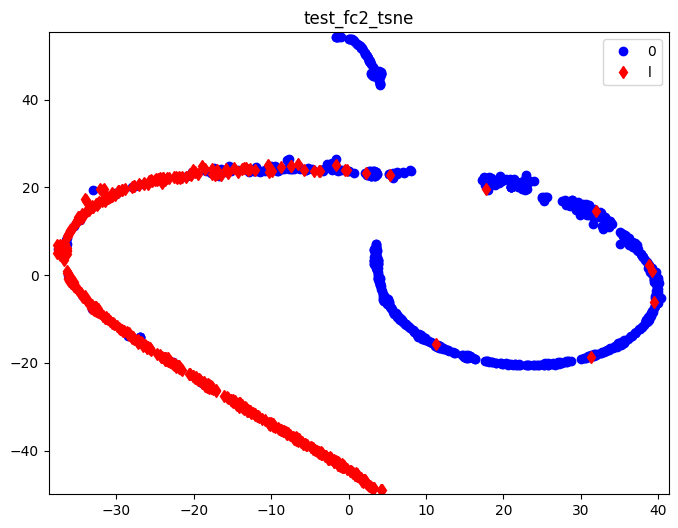

In [22]:
# 对输出进行降维并可视化
test_fc2_tsne = TSNE(n_components=2).fit_transform(test_fc2.data.numpy())
# 将特征进行可视化
plt.figure(figsize=(8, 6))
# 可视化前设置坐标系的取值范围
plt.xlim([min(test_fc2_tsne[:, 0]-1), max(test_fc2_tsne[:, 0])+1])
plt.ylim([min(test_fc2_tsne[:, 1]-1), max(test_fc2_tsne[:, 1])+1])
plt.plot(test_fc2_tsne[y_test == 0, 0], test_fc2_tsne[y_test == 0, 1], "bo", label='0')
plt.plot(test_fc2_tsne[y_test == 1, 0], test_fc2_tsne[y_test == 1, 1], "rd", label="l")
plt.legend()
plt.title("test_fc2_tsne")
plt.show()

#### 2.使用钩子获取中间层的输出

In [23]:
# 定义一个辅助函数，来获取指定层名称的特征
activation = {} # 保存不同层的输出
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
# 全连接网络获取分类层的输出
mlpc.classifica.register_forward_hook(get_activation("classifica"))
_, _, _ = mlpc(X_test_t)
classifica = activation["classifica"].data.numpy()
print("classifica.shape:", classifica.shape)

classifica.shape: (1151, 2)


> 上述程序先使用mlpc.classifica.register_forward_hook(get_activation("classifica"))操作（该操作主要用于获取classifica层的输出结果），然后将训练好的网络mlpc作用于测试集X_test_t，这样在activation字典中，键值classifica对应的结果即为想要获取的中间层特征

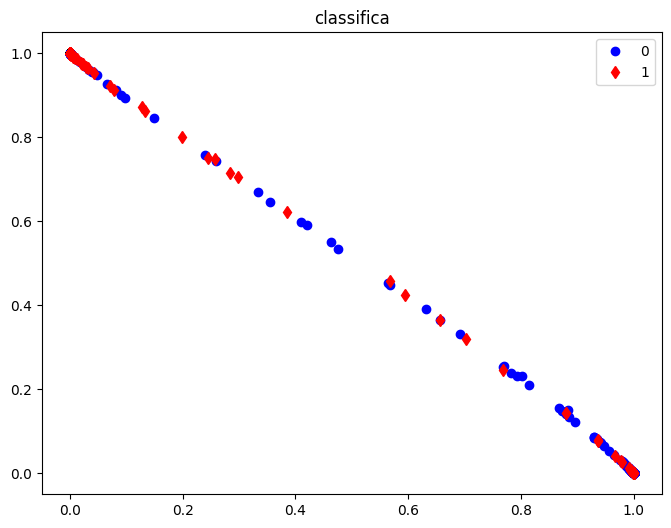

In [24]:
# 将特征进行可视化
plt.figure(figsize=(8, 6))
# 可视化每类的散点图
plt.plot(classifica[y_test == 0, 0], classifica[y_test == 0, 1], "bo", label = "0")
plt.plot(classifica[y_test == 1, 0], classifica[y_test == 1, 1], "rd", label = "1")
plt.legend()
plt.title("classifica")
plt.show()